In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from os import path
import glob

from src.utils import *
from src.forward_model import *

In [3]:
obj_dims = (648, 486)

In [4]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Ground truth record path
gt_path = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/dataset_1/ground_truths')
gt_files = glob.glob(path.join(gt_path, '*'))

In [5]:
# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

psf = tf.squeeze(tf.math.reduce_sum(h*weights, axis=0))
psf = psf / tf.math.reduce_max(psf)

In [6]:
# TFRecord Utils
feature_description = {
    'plane': tf.io.FixedLenFeature(obj_dims, tf.float32)
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [7]:
raw_dataset = tf.data.TFRecordDataset(filenames=gt_files)
dataset = raw_dataset.map(_parse_function)

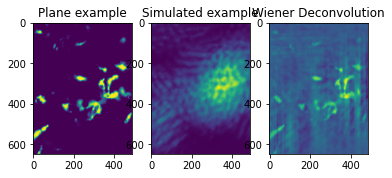

In [8]:
# Visualize a random example and its simulation from convolution
dataset_iter = iter(dataset.shuffle(32))
plane_example = next(dataset_iter)['plane'].numpy()

model = ForwardModel()
sim_example = model.convolve_tf(plane_example, psf)

fig = plt.figure()

ax1 = plt.subplot(131)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(132)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

ax3 = plt.subplot(133)
ax3.imshow(model.wiener_deconvolve_one_step(sim_example, psf, 1000))
ax3.set_title('Wiener Deconvolution')

plt.show()

In [9]:
class ADMM_model(tf.keras.Model):
    def __init__(self, h, iterations):
        super(ADMM_model, self).__init__()
        
        self.iterations = iterations
        self.DIMS0 = h.shape[0]
        self.DIMS1 = h.shape[1]
        
        self.PAD_SIZE0 = int((self.DIMS0)//2)
        self.PAD_SIZE1 = int((self.DIMS1)//2)
        
        self.h_var = tf.Variable(initial_value=h, dtype=tf.float32, trainiable=False)
        self.h_zeroes = tf.Variable(initial_value=tf.zeros(self.DIMS0*2, self.DIMS1*2), dtype=tf.float32, trainable=False)
        self.h_complex = tf.stack()